# Simulation

In this tutorial, you are going to simulate the spread of COVID-19 for an artificial
data set. First, some imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sid import simulate

N_INDIVIDUALS = 10_000
N_INFECTIOUS = 100
N_PERIODS = 200

index_cols = ["category", "subcategory", "name"]

At first, we are loading some pre-defined parameters.

In [2]:
params = pd.read_csv("../../../sid/params.csv", index_col=index_cols)

Next, simulate some data on individuals which have two characteristics, an age group and
a country they live in.

In [3]:
age_group = np.random.choice(
    [
        "0 - 9",
        "10 - 19",
        "20 - 29",
        "30 - 39",
        "40 - 49",
        "50 - 59",
        "60 - 69",
        "70 - 79",
        "80 - 100",
    ],
    size=N_INDIVIDUALS,
)
region = np.random.choice(["Drenthe", "Gelderland", "Overtjssel"], size=N_INDIVIDUALS)

initial_states = pd.DataFrame({"age_group": age_group, "region": region}).astype(
    "category"
)
initial_states.head(5)

,age_group,region
0,70 - 79,Gelderland
1,60 - 69,Gelderland
2,0 - 9,Drenthe
3,20 - 29,Overtjssel
4,20 - 29,Gelderland


For the simulation, we need at least one individual which is infected.

In [4]:
initial_infections = pd.Series(data=False, index=initial_states.index)

infected_individuals = initial_infections.sample(N_INFECTIOUS, random_state=0).index
initial_infections.loc[infected_individuals] = True

Furthermore, we need to define how many contacts people have. We assume people have two
types of contacts, close and distant contacts. They also have fewer close than distant
contacts.

In [5]:
def meet_distant(states, params, period):
    contacts = np.random.choice(10, size=len(states))
    return pd.Series(contacts, index=states.index)


def meet_close(states, params, period):
    contacts = np.random.choice(5, size=len(states))
    return pd.Series(contacts, index=states.index)


assort_by = ["age_group", "region"]

contact_models = {
    "distant": {"model": meet_distant, "assort_by": assort_by},
    "close": {"model": meet_close, "assort_by": assort_by},
}

Sid allows to estimate one infection probability per contact type. 
In this example, close contacts are more infectious as distant contacts with 5% versus 3%.


In [6]:
inf_params = pd.read_csv("infection_probs.csv", index_col=index_cols)
params = params.append(inf_params)
inf_params

value  note  source
category       subcategory name                     
infection_prob close       NaN    0.05   NaN     NaN
               distant     NaN    0.03   NaN     NaN

Similarily, we can specify for each contact model how assortative 
people meet across their respective `assort_by` keys. 

We assume that 90% of contacts are with people from the same region and 50% with contacts of the same age group as oneself for both "meet_close" and "meet_distant". 
The rest of the probability mass is split evenly between the other regions and age groups.

In [7]:
assort_probs = pd.read_csv("assort_by_params.csv", index_col=index_cols)
params = params.append(assort_probs)
assort_probs

value  note  source
category             subcategory name                          
assortative_matching close       age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN
                     distant     age_group    0.5   NaN     NaN
                                 region       0.9   NaN     NaN

We also allow the government to react to the rising number of infections by enforcing a
mild curfew which halves the contacts of all individuals if 10% of all individuals are
infectious.

In [8]:
def contact_policy_is_active(states):
    return states["infectious"].mean() > 0.1


contact_policies = {
    "close": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
    "distant": {
        "start": "2020-03-12",
        "multiplier": 0.5,
        "is_active": contact_policy_is_active,
    },
}

We are going to simulate this population for 200 periods.

In [9]:
df = simulate(
    params=params,
    initial_states=initial_states,
    initial_infections=initial_infections,
    contact_models=contact_models,
    duration={"start": "2020-02-27", "periods": N_PERIODS},
    contact_policies=contact_policies,
    seed=0,
)
df.head(5)

,index,age_group,region,ever_infected,immune,infectious,knows,symptoms,needs_icu,dead,cd_infectious_false,infection_counter,date,period,missed_close,missed_distant,close,distant,infections
0,0,70 - 79,Gelderland,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
1,1,60 - 69,Gelderland,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
2,2,0 - 9,Drenthe,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
3,3,20 - 29,Overtjssel,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False
4,4,20 - 29,Gelderland,False,False,False,False,False,False,False,-3,0,2020-02-27,0,0,0,0,0,False


The return of :func:`simulate` is a [Dask DataFrame](https://docs.dask.org/en/latest/dataframe.html) which lazily loads the data. If your data fits your working memory, do the following to convert it to a pandas DataFrame.

In [10]:
df = df.compute()

Let us take a look at various statistics of the sample.

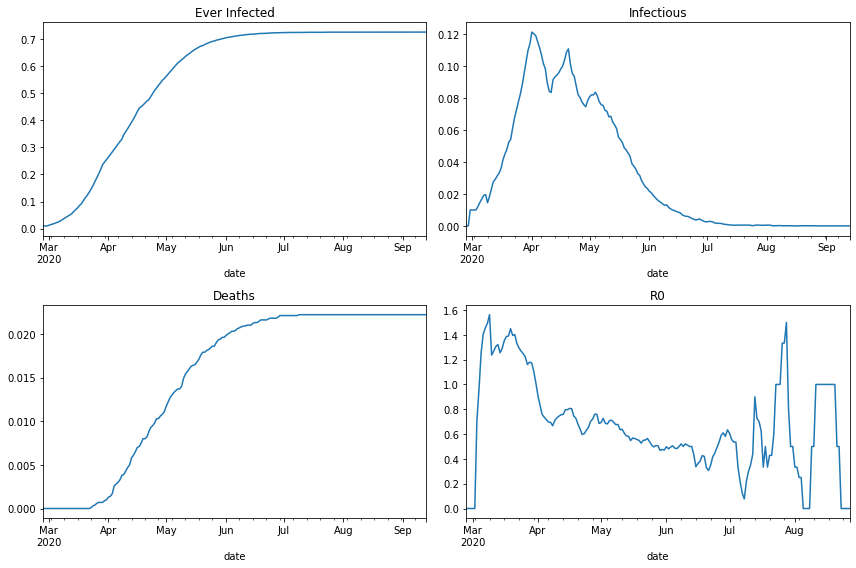

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

axs = axs.flatten()

df.groupby("date").ever_infected.mean().plot(ax=axs[0])
df.groupby("date").infectious.mean().plot(ax=axs[1])
df.groupby("date").dead.mean().plot(ax=axs[2])

infectious_last_seven_days = df.cd_infectious_false.between(-7, 0)
df.loc[infectious_last_seven_days].groupby("date").infection_counter.mean().plot(
    ax=axs[3]
)

axs[0].set_title("Ever Infected")
axs[1].set_title("Infectious")
axs[2].set_title("Deaths")
axs[3].set_title("R0")

fig.tight_layout()